#**INTRODUCTION TO ALGORITHMIC TRADING**

---

##0.REFERENCE

https://claude.ai/share/ca635e35-ed4a-4cdf-9247-0a16516ed73a

## 1.CONTEXT



**WELCOME TO THE LABORATORY**

This is the first of 25 hands-on notebooks that accompany the book
*AI and Algorithmic Trading*. While the book develops theory, intuition, and
conceptual frameworks, these notebooks are your **laboratory**—a place to turn
ideas into executable code, to test hypotheses on controlled data, and to build
trading systems from first principles.

Unlike most finance tutorials that hand you DataFrames full of historical prices
and tell you to "fit this model," we take a radically different approach:

**We build our own synthetic markets.**

Why? Because when you generate the data yourself, you know the **ground truth**.
You control the drift, the volatility, the correlations, the regime changes. You
can plant specific patterns—mean reversion, momentum, factor premia—and then test
whether your algorithms successfully recover them. This transforms learning from
passive pattern-matching into active scientific inquiry.

**WHAT YOU'LL BUILD IN THIS NOTEBOOK**


Today's lab establishes the foundational workflow that every subsequent notebook
will follow:

1. **Data Generation (DGP)**: We explicitly define a data-generating process for
   a small universe of synthetic assets. Each asset has a distinct character—one
   is a stable grower, one mean-reverts, one is volatile and trendy. We encode
   these properties mathematically and generate price paths using only Python's
   standard library and basic numerical tools.

2. **Market Exploration**: From these synthetic prices, we compute returns,
   volatilities, and correlations **by hand**—using loops and formulas, not
   high-level libraries. This forces you to understand what these statistics
   actually mean and where they come from.

3. **Signal Generation**: We implement a minimal "signal engine"—in this case,
   a dual moving average crossover strategy. This is deliberately simple; later
   notebooks will replace it with machine learning, deep learning, and
   reinforcement learning models. But the structure remains the same: signals
   emerge from data, not magic.

4. **Backtesting & Evaluation**: We build a transparent backtest loop that
   respects time: no look-ahead bias, no hidden future information. We compute
   profit-and-loss step by step, track an equity curve, and calculate basic
   performance metrics like Sharpe ratios and drawdowns.

5. **Governance & Logging**: We introduce simple structures—dictionaries and
   lists—to record our experimental setup, parameters, and results. This makes
   our work reproducible, auditable, and comparable. It's the seed of what will
   grow into full experiment tracking, model registries, and production monitoring
   systems.

**THE PHILOSOPHY: MARKETS AS INFORMATION ENGINES**


Throughout these notebooks, we treat markets not as mysterious black boxes, but
as **information engines** that aggregate beliefs, process signals, and produce
prices. When we build synthetic markets, we're building simplified versions of
these engines—engines whose internal logic we fully understand.

This approach serves two purposes:

- **Pedagogically**, it demystifies finance. You see that prices are just numbers
  generated by rules. Returns are differences. Volatility is standard deviation.
  There's no magic, only math and code.

- **Practically**, it prepares you for real-world challenges. In production, you
  must constantly ask: "What is my model actually learning? Is it exploiting a
  genuine pattern or fitting noise? How will it behave when market conditions
  change?" Synthetic data trains you to think this way.

**THE CODING DISCIPLINE: PURE PYTHON, NO PANDAS**


You'll notice we avoid `pandas` and high-level abstractions. This is intentional.
We use lists, dictionaries, tuples, and small classes—the fundamental building
blocks of Python. We compute statistics with loops before reaching for library
functions.

Why this discipline? Because:

- It forces **clarity**. When you write the loop yourself, you understand exactly
  what's happening at each step.
- It builds **transferable skills**. Lists and dicts work everywhere—in web
  servers, in databases, in distributed systems. DataFrames don't.
- It prepares you for **production**. Real trading systems often operate on
  streaming data, event logs, and custom structures. The habits you build here—
  explicit indexing, careful time-ordering, modular functions—will serve you well.

**WHAT'S NEXT**


This first notebook is foundational. The strategy is simple, the data is clean,
the patterns are obvious. But the **structure** we establish here—DGP → Signal →
Execution → Evaluation → Governance—will remain constant as we progress through:

- Classical statistical models (ARIMA, GARCH, factor models)
- Supervised learning (regression, trees, ensembles)
- Deep learning (CNNs, RNNs, attention mechanisms)
- Reinforcement learning (Q-learning, policy gradients)
- Agentic architectures (multi-model systems with orchestration and reasoning)

Each notebook will add complexity and sophistication, but always anchored in
synthetic data we generate and control.

Ready? Let's build our first market.


## 2.LIBRARIES AND ENVIRONMENT

In [1]:
import random
import math
from typing import List, Dict, Tuple

# Optional numerical and plotting support
import numpy as np
import matplotlib.pyplot as plt

print("Lab 01: Foundations — Imports Complete")

Lab 01: Foundations — Imports Complete


## 3.DATA GENERATION

###3.1.OVERVIEW


**THE DATA-GENERATING PROCESS AS FIRST-CLASS CITIZEN**


In most finance courses, data simply "appears"—a CSV file of historical prices,
a DataFrame downloaded from an API. You're told to clean it, analyze it, model it.
But you never ask: **Where did these numbers come from? What process generated them?
What is true in this data, and what is noise?**

We take the opposite approach. In this laboratory, **data generation is not a
preprocessing step—it's the foundation of scientific inquiry.** Before we can test
whether an algorithm works, we must define what "works" means. Before we can
evaluate a signal, we must know what patterns actually exist to be found.

**BUILDING A SYNTHETIC UNIVERSE**


Today we create a micro-universe of three assets, each with distinct economic
character:

**ASSET_A: "Stable Grower"** follows a geometric random walk with modest positive
drift and low volatility. Think of a large-cap equity or investment-grade bond—
steady appreciation, limited downside risk.

**ASSET_B: "Mean Reverter"** exhibits pull toward an equilibrium price. It wanders,
but gravity brings it back. This mimics spreads, commodities with production costs,
or pairs trades. The mean-reversion parameter κ (kappa) controls how quickly prices
return to center.

**ASSET_C: "Volatile Trendy"** combines high drift with high volatility. It can
deliver spectacular gains or brutal drawdowns. Think emerging markets, growth stocks,
or crypto assets.

Critically, all three assets share a **common market shock**—40% of each asset's
daily innovation comes from a single random variable. This creates realistic
correlation structure. Markets don't move independently; systematic factors drive
co-movement.

**WHAT IS "TRUE" IN OUR WORLD**


By constructing the DGP explicitly, we encode ground truth:

- Asset A *should* deliver ~5% annual returns (we set the drift)
- Asset B *should* cluster around $100 (we set the mean-reversion target)
- Asset C *should* exhibit ~25% annualized volatility (we set the noise level)
- All assets *should* show positive correlation (we set the market shock weight)

Later, when we backtest strategies, we can ask: **Did our algorithm successfully
exploit these planted patterns? Or did it chase noise?** This is the scientific
method applied to quantitative finance.

**THE CODE: TRANSPARENT, REPRODUCIBLE, EXTENSIBLE**


Our DGP implementation uses pure Python with optional NumPy. Every parameter is
explicit. Every random seed is fixed. Every assumption is documented. This isn't
just pedagogical—it's how you'd design a production simulation engine for stress
testing, scenario analysis, or strategy validation.

Let's generate our market.



###3.2.CODE AND IMPLEMENTATION

In [5]:
RANDOM_SEED = 42
N_DAYS = 252  # One trading year
INITIAL_PRICE = 100.0

# Asset A: Stable Grower
DRIFT_A = 0.05 / 252  # 5% annual drift, daily
VOL_A = 0.10 / math.sqrt(252)  # 10% annual vol, daily

# Asset B: Mean Reverter
MEAN_LEVEL_B = math.log(100.0)  # Mean revert to log(100)
KAPPA_B = 0.05  # Mean reversion speed
VOL_B = 0.15 / math.sqrt(252)  # 15% annual vol, daily

# Asset C: Volatile Trendy
DRIFT_C = 0.12 / 252  # 12% annual drift, daily
VOL_C = 0.25 / math.sqrt(252)  # 25% annual vol, daily

# Correlation structure: all assets share a common market shock
MARKET_SHOCK_WEIGHT = 0.4  # 40% of each asset's shock is common

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"DGP Configuration:")
print(f"  Time Horizon: {N_DAYS} days")
print(f"  Asset A: drift={DRIFT_A*252:.1%}/yr, vol={VOL_A*math.sqrt(252):.1%}/yr")
print(f"  Asset B: mean-reversion kappa={KAPPA_B:.3f}, vol={VOL_B*math.sqrt(252):.1%}/yr")
print(f"  Asset C: drift={DRIFT_C*252:.1%}/yr, vol={VOL_C*math.sqrt(252):.1%}/yr")
print(f"  Market shock correlation weight: {MARKET_SHOCK_WEIGHT:.1%}")

# %%
# SYNTHETIC PRICE GENERATION FUNCTIONS

def generate_geometric_random_walk(
    n_steps: int,
    initial_price: float,
    drift: float,
    volatility: float,
    market_shocks: List[float],
    idio_shocks: List[float],
    market_weight: float
) -> List[float]:
    """
    Generate a geometric random walk price series.

    Price evolves as:
      P(t) = P(t-1) * exp(drift + volatility * combined_shock(t))

    where combined_shock = market_weight * market_shock + sqrt(1-market_weight^2) * idio_shock

    This ensures:
      - Total variance remains volatility^2
      - Assets share common market_shock component

    Args:
        n_steps: Number of time steps
        initial_price: Starting price
        drift: Expected log-return per step
        volatility: Volatility per step (std dev of log-returns)
        market_shocks: List of common market shocks
        idio_shocks: List of idiosyncratic shocks
        market_weight: Weight on market shock (0 to 1)

    Returns:
        List of prices (length n_steps + 1, including initial price)
    """
    prices = [initial_price]
    idio_weight = math.sqrt(1 - market_weight**2)

    for t in range(n_steps):
        # Combine market and idiosyncratic shocks
        combined_shock = (market_weight * market_shocks[t] +
                         idio_weight * idio_shocks[t])

        # Geometric random walk step
        log_return = drift + volatility * combined_shock
        new_price = prices[-1] * math.exp(log_return)
        prices.append(new_price)

    return prices


def generate_mean_reverting_series(
    n_steps: int,
    initial_price: float,
    mean_level: float,
    kappa: float,
    volatility: float,
    market_shocks: List[float],
    idio_shocks: List[float],
    market_weight: float
) -> List[float]:
    """
    Generate a mean-reverting price series.

    log(P) evolves with mean reversion:
      log(P(t)) = log(P(t-1)) + kappa * (mean_level - log(P(t-1)))
                  + volatility * combined_shock(t)

    Args:
        n_steps: Number of time steps
        initial_price: Starting price
        mean_level: Log-price level to revert to
        kappa: Mean reversion speed (0 to 1, higher = faster)
        volatility: Volatility per step
        market_shocks: List of common market shocks
        idio_shocks: List of idiosyncratic shocks
        market_weight: Weight on market shock

    Returns:
        List of prices (length n_steps + 1, including initial price)
    """
    log_price = math.log(initial_price)
    prices = [initial_price]
    idio_weight = math.sqrt(1 - market_weight**2)

    for t in range(n_steps):
        # Mean reversion component
        log_price += kappa * (mean_level - log_price)

        # Volatility component with combined shocks
        combined_shock = (market_weight * market_shocks[t] +
                         idio_weight * idio_shocks[t])
        log_price += volatility * combined_shock

        # Convert back to price
        new_price = math.exp(log_price)
        prices.append(new_price)

    return prices


# %%
# GENERATE SYNTHETIC MARKET

# Generate common market shocks and idiosyncratic shocks for each asset
# Using standard normal random variables
market_shocks = [random.gauss(0, 1) for _ in range(N_DAYS)]

idio_shocks_A = [random.gauss(0, 1) for _ in range(N_DAYS)]
idio_shocks_B = [random.gauss(0, 1) for _ in range(N_DAYS)]
idio_shocks_C = [random.gauss(0, 1) for _ in range(N_DAYS)]

# Generate price series for each asset
prices_A = generate_geometric_random_walk(
    N_DAYS, INITIAL_PRICE, DRIFT_A, VOL_A,
    market_shocks, idio_shocks_A, MARKET_SHOCK_WEIGHT
)

prices_B = generate_mean_reverting_series(
    N_DAYS, INITIAL_PRICE, MEAN_LEVEL_B, KAPPA_B, VOL_B,
    market_shocks, idio_shocks_B, MARKET_SHOCK_WEIGHT
)

prices_C = generate_geometric_random_walk(
    N_DAYS, INITIAL_PRICE, DRIFT_C, VOL_C,
    market_shocks, idio_shocks_C, MARKET_SHOCK_WEIGHT
)

# Store in dictionary (our "universe")
prices = {
    "ASSET_A": prices_A,
    "ASSET_B": prices_B,
    "ASSET_C": prices_C
}

print(f"\nSynthetic Market Generated:")
print(f"  Universe: {list(prices.keys())}")
print(f"  Time steps: {len(prices_A)} (including initial price)")
print(f"  Final prices:")
for asset, price_list in prices.items():
    print(f"    {asset}: {price_list[0]:.2f} → {price_list[-1]:.2f}")



DGP Configuration:
  Time Horizon: 252 days
  Asset A: drift=5.0%/yr, vol=10.0%/yr
  Asset B: mean-reversion kappa=0.050, vol=15.0%/yr
  Asset C: drift=12.0%/yr, vol=25.0%/yr
  Market shock correlation weight: 40.0%

Synthetic Market Generated:
  Universe: ['ASSET_A', 'ASSET_B', 'ASSET_C']
  Time steps: 253 (including initial price)
  Final prices:
    ASSET_A: 100.00 → 108.56
    ASSET_B: 100.00 → 101.06
    ASSET_C: 100.00 → 92.79


##4.CORE MARKET AND DATA EXPLORATION

###4.1.OVERVIEW

###4.2.CODE AND IMPLEMENTATION

Returns computed for all assets
  Number of return observations: 252

SUMMARY STATISTICS (Manual Computation)

ASSET_A:
  Daily mean return:     0.000346  (0.0346%)
  Daily volatility:      0.006311  (0.6311%)
  Annualized mean:         0.0871  (8.71%)
  Annualized volatility:   0.1002  (10.02%)

ASSET_B:
  Daily mean return:     0.000088  (0.0088%)
  Daily volatility:      0.009601  (0.9601%)
  Annualized mean:         0.0221  (2.21%)
  Annualized volatility:   0.1524  (15.24%)

ASSET_C:
  Daily mean return:     -0.000154  (-0.0154%)
  Daily volatility:      0.016943  (1.6943%)
  Annualized mean:        -0.0388  (-3.88%)
  Annualized volatility:   0.2690  (26.90%)

CORRELATION MATRIX (Manual Computation)

This measures linear co-movement between asset returns.
Range: -1 (perfect negative) to +1 (perfect positive)

           ASSET_A   ASSET_B   ASSET_C
 ASSET_A:   1.0000    0.1369    0.0138
 ASSET_B:   0.1369    1.0000    0.1850
 ASSET_C:   0.0138    0.1850    1.0000

INTERPRETATION:


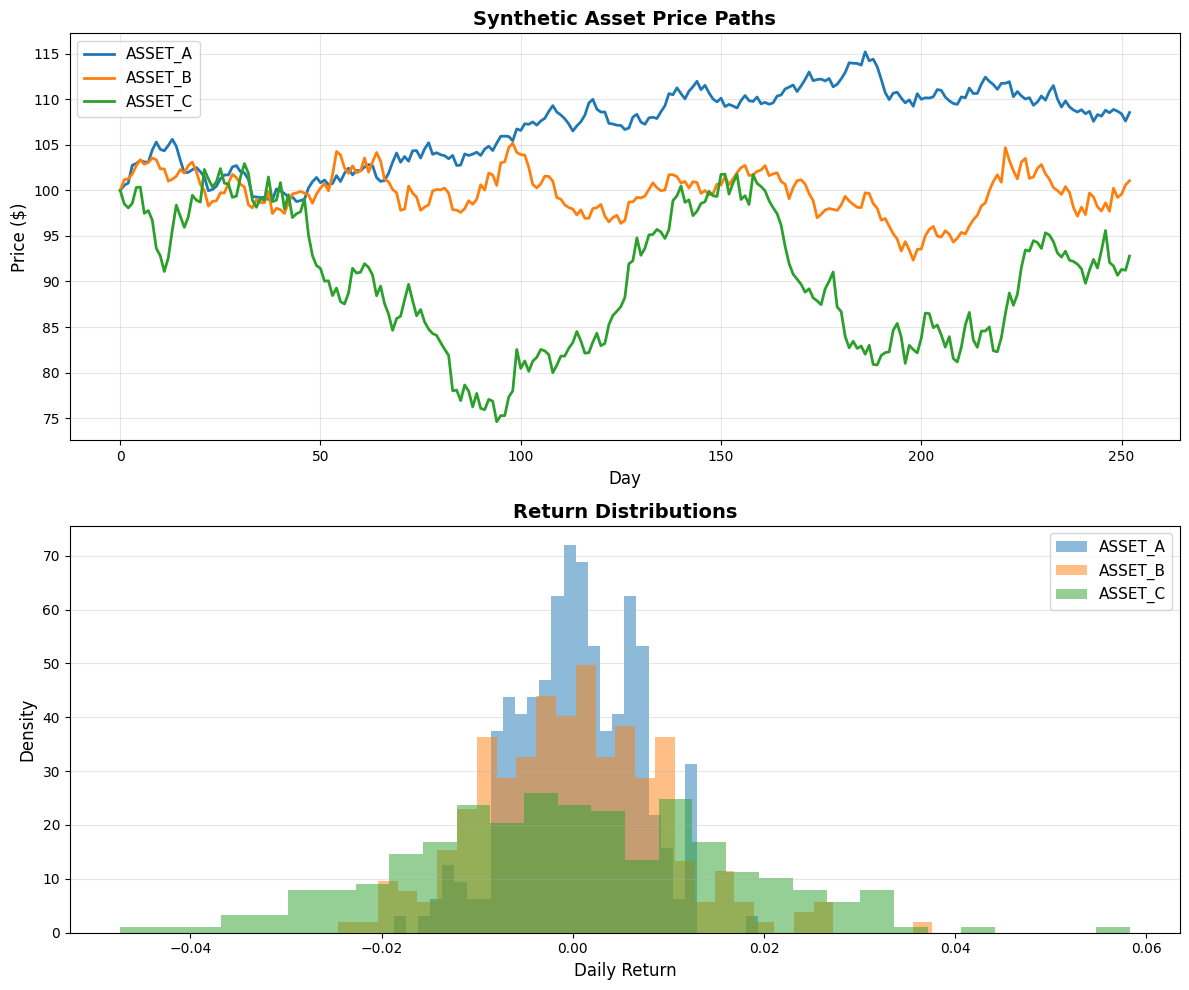


Visualization: Price paths show different dynamics per DGP design
               Return distributions reveal vol differences


In [6]:
# COMPUTE SIMPLE RETURNS

def compute_simple_returns(prices: List[float]) -> List[float]:
    """
    Compute simple returns: r(t) = (P(t) - P(t-1)) / P(t-1)

    Args:
        prices: List of prices (length n+1)

    Returns:
        List of returns (length n)
    """
    returns = []
    for t in range(1, len(prices)):
        ret = (prices[t] - prices[t-1]) / prices[t-1]
        returns.append(ret)
    return returns


# Compute returns for all assets
returns = {}
for asset, price_list in prices.items():
    returns[asset] = compute_simple_returns(price_list)

print("Returns computed for all assets")
print(f"  Number of return observations: {len(returns['ASSET_A'])}")


# MANUAL COMPUTATION OF SUMMARY STATISTICS

def compute_mean_manual(values: List[float]) -> float:
    """
    Compute arithmetic mean: mean = sum(x_i) / n

    This is the first moment of the distribution.
    """
    return sum(values) / len(values)


def compute_variance_manual(values: List[float]) -> float:
    """
    Compute sample variance: var = sum((x_i - mean)^2) / (n - 1)

    We use n-1 (Bessel's correction) for unbiased estimation.
    This is the second central moment.
    """
    mean = compute_mean_manual(values)
    squared_deviations = [(x - mean)**2 for x in values]
    return sum(squared_deviations) / (len(values) - 1)


def compute_std_manual(values: List[float]) -> float:
    """
    Compute standard deviation: std = sqrt(variance)

    This is the square root of variance, in the same units as the data.
    """
    return math.sqrt(compute_variance_manual(values))


def compute_correlation_manual(x: List[float], y: List[float]) -> float:
    """
    Compute Pearson correlation coefficient:

    corr(X,Y) = cov(X,Y) / (std(X) * std(Y))

    where cov(X,Y) = E[(X - E[X])(Y - E[Y])]

    This measures linear association between -1 and +1.
    """
    if len(x) != len(y):
        raise ValueError("Series must have same length")

    mean_x = compute_mean_manual(x)
    mean_y = compute_mean_manual(y)

    # Compute covariance
    cov = sum((x[i] - mean_x) * (y[i] - mean_y) for i in range(len(x))) / (len(x) - 1)

    # Compute standard deviations
    std_x = compute_std_manual(x)
    std_y = compute_std_manual(y)

    # Correlation
    return cov / (std_x * std_y)



# COMPUTE AND DISPLAY STATISTICS

print("\n" + "="*70)
print("SUMMARY STATISTICS (Manual Computation)")
print("="*70)

stats = {}
for asset, ret_list in returns.items():
    mean_ret = compute_mean_manual(ret_list)
    std_ret = compute_std_manual(ret_list)

    # Annualize for interpretation (252 trading days)
    annual_mean = mean_ret * 252
    annual_vol = std_ret * math.sqrt(252)

    stats[asset] = {
        "mean_daily": mean_ret,
        "std_daily": std_ret,
        "mean_annual": annual_mean,
        "vol_annual": annual_vol
    }

    print(f"\n{asset}:")
    print(f"  Daily mean return:     {mean_ret:>8.6f}  ({mean_ret*100:.4f}%)")
    print(f"  Daily volatility:      {std_ret:>8.6f}  ({std_ret*100:.4f}%)")
    print(f"  Annualized mean:       {annual_mean:>8.4f}  ({annual_mean*100:.2f}%)")
    print(f"  Annualized volatility: {annual_vol:>8.4f}  ({annual_vol*100:.2f}%)")


# COMPUTE CORRELATION MATRIX (MANUAL)

print("\n" + "="*70)
print("CORRELATION MATRIX (Manual Computation)")
print("="*70)
print("\nThis measures linear co-movement between asset returns.")
print("Range: -1 (perfect negative) to +1 (perfect positive)")
print()

asset_names = list(returns.keys())
n_assets = len(asset_names)

# Build correlation matrix as nested lists
corr_matrix = []
for i in range(n_assets):
    row = []
    for j in range(n_assets):
        if i == j:
            corr = 1.0  # Asset perfectly correlated with itself
        else:
            corr = compute_correlation_manual(
                returns[asset_names[i]],
                returns[asset_names[j]]
            )
        row.append(corr)
    corr_matrix.append(row)

# Display correlation matrix
print("         ", "  ".join(f"{name:>8}" for name in asset_names))
for i, name in enumerate(asset_names):
    print(f"{name:>8}:", "  ".join(f"{corr_matrix[i][j]:>8.4f}" for j in range(n_assets)))

print("\nINTERPRETATION:")
print(f"  All assets show positive correlation due to common market shock")
print(f"  (market_weight = {MARKET_SHOCK_WEIGHT:.1%} of each asset's variance)")


# VISUALIZATIONS

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Price Paths
ax1 = axes[0]
for asset, price_list in prices.items():
    days = list(range(len(price_list)))
    ax1.plot(days, price_list, label=asset, linewidth=2)

ax1.set_xlabel("Day", fontsize=12)
ax1.set_ylabel("Price ($)", fontsize=12)
ax1.set_title("Synthetic Asset Price Paths", fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Return Distributions (Histograms)
ax2 = axes[1]
for asset, ret_list in returns.items():
    ax2.hist(ret_list, bins=30, alpha=0.5, label=asset, density=True)

ax2.set_xlabel("Daily Return", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("Return Distributions", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nVisualization: Price paths show different dynamics per DGP design")
print("               Return distributions reveal vol differences")

##5.SIMPLE SIGNAL/STRATEGY SKELETON

###5.1.OVERVIEW



**FROM OBSERVATION TO ACTION: THE SIGNAL ENGINE**


We've generated synthetic prices. We've computed statistics. We understand our
market's characteristics—drift, volatility, correlations. But understanding is
not action. To trade, we need a **decision rule**: a systematic process that
transforms market observations into positions.

This is the role of the **signal engine**—the component that says "buy," "sell,"
or "do nothing" based on available information. In modern algorithmic trading,
signal engines range from simple rules (like ours today) to sophisticated machine
learning models that process millions of features. But the conceptual structure
remains constant:

**Input**: Observable market data (prices, volumes, news, etc.)  
**Process**: Computation or inference that identifies patterns or opportunities  
**Output**: A signal—typically a number representing direction and conviction  

**THE DUAL MOVING AVERAGE CROSSOVER: A CLASSICAL BASELINE**


Today we implement one of the oldest, most studied technical strategies: the
**dual moving average crossover**. The logic is disarmingly simple:

- Compute a **short-term moving average** (e.g., 20-day): captures recent momentum
- Compute a **long-term moving average** (e.g., 50-day): captures broader trend
- **When short MA crosses above long MA**: interpret as bullish momentum → go LONG
- **When short MA crosses below long MA**: interpret as bearish momentum → go SHORT

This strategy embodies a hypothesis: **trends persist in the medium term**. If
recent prices are rising faster than the historical average, the asset is gaining
upward momentum. If recent prices are falling relative to history, momentum is
negative.

Is this hypothesis true? It depends on the market. In our synthetic world, we
planted positive drift in Asset A—a trending component by construction. The moving
average strategy should capture some of this. But it will also suffer from **lag**:
moving averages are backward-looking, so they react slowly to reversals.

**WHY START WITH SOMETHING SO SIMPLE?**

You might wonder: why implement a strategy from the 1970s in a book about AI and
algorithmic trading? Three reasons:

**1. Baseline and Benchmark**  
Before deploying sophisticated machine learning, you need to know: what can a
simple rule achieve? If a 10-line moving average beats your neural network, your
neural network is broken. Simple strategies are **baselines**—the minimum
performance bar for more complex methods.

**2. Transparency and Interpretability**  
Moving averages are fully interpretable. Every signal has a clear mathematical
justification. When something goes wrong, you can trace the logic. Contrast this
with a deep learning model: when it says "sell," can you explain why?
Interpretability isn't academic—it's essential for risk management, compliance,
and debugging.

**3. Modular Architecture**  
The structure we build today—a signal function that takes prices and returns
positions—is the **interface** every signal engine must satisfy. Whether we're
using moving averages, random forests, LSTMs, or reinforcement learning agents,
the input/output contract is the same:
```
def generate_signal(market_data, parameters) -> signal
```

Later notebooks will replace the internals of this function with increasingly
sophisticated methods, but the architecture remains constant.

**THE IMPLEMENTATION: MANUAL COMPUTATION, EXPLICIT LOGIC**


We compute moving averages **manually** using loops—no `.rolling()`, no hidden
library magic. Why? Because when you write the loop yourself, you confront
critical questions:

- **Warmup period**: How many observations do I need before the long MA is valid?
- **Time alignment**: Does the signal at time t use data *up to* t or *through* t+1?
- **Look-ahead bias**: Am I accidentally using future information?

These questions aren't theoretical. Look-ahead bias—using tomorrow's price to make
today's decision—is the #1 cause of backtesting disasters. Strategies that appear
profitable in simulation crash in live trading because the backtest "cheated."

Our manual implementation makes time-ordering **explicit and transparent**. At
time t, we compute moving averages using only prices from t-window+1 through t.
The signal generated at time t determines the position held from t to t+1. The
return realized during [t, t+1] is the return we trade on.

No ambiguity. No accidents.

**A TOY ENGINE FOR A REAL ARCHITECTURE**


Make no mistake: this moving average strategy is a **toy**. It ignores transaction
costs, market impact, regime changes, and a thousand other real-world complexities.
It will not make you rich.

But it establishes the **pattern**: observe → compute → signal → position. This
pattern scales. In Notebook 10, we'll replace "compute moving averages" with
"train a gradient-boosted tree." In Notebook 20, we'll replace it with "query a
large language model for reasoning." But the structure—the clean separation
between data, signal generation, and execution—remains.

Let's build our first signal engine.



###5.2.CODE AND IMPLEMENTATION

In [8]:
# %%
# MOVING AVERAGE FUNCTIONS

def compute_simple_moving_average(
    values: List[float],
    window: int,
    index: int
) -> float:
    """
    Compute simple moving average ending at index.

    SMA(window, index) = mean(values[index-window+1 : index+1])

    Args:
        values: Time series (prices or returns)
        window: Number of periods in the average
        index: End index (inclusive)

    Returns:
        Moving average value, or None if insufficient data
    """
    if index < window - 1:
        return None  # Not enough data yet

    # Extract window of data ending at index
    start = index - window + 1
    window_data = values[start:index+1]

    # Compute mean
    return sum(window_data) / len(window_data)


# %%
# SIGNAL GENERATION

# We'll generate signals for ASSET_A
TARGET_ASSET = "ASSET_A"
SHORT_WINDOW = 20  # Short MA: 20 days
LONG_WINDOW = 50   # Long MA: 50 days

target_prices = prices[TARGET_ASSET]

print(f"\nSignal Engine Configuration:")
print(f"  Target Asset: {TARGET_ASSET}")
print(f"  Short MA Window: {SHORT_WINDOW} days")
print(f"  Long MA Window: {LONG_WINDOW} days")
print(f"  Warmup Period: {LONG_WINDOW} days (until long MA is valid)")

# Generate signals for each time step
# Note: We generate signals on PRICES, not returns
# Signal at time t uses prices up to and including time t
# Position based on signal[t] is held from t to t+1

signals = []

for t in range(len(target_prices)):
    # Compute both moving averages
    sma = compute_simple_moving_average(target_prices, SHORT_WINDOW, t)
    lma = compute_simple_moving_average(target_prices, LONG_WINDOW, t)

    # Generate signal
    if sma is None or lma is None:
        # Warmup period: not enough data
        signal = 0
    elif sma > lma:
        # Short MA above long MA: bullish, go LONG
        signal = 1
    else:
        # Short MA below long MA: bearish, go SHORT
        signal = -1

    signals.append(signal)

# Count signal distribution
signal_counts = {-1: 0, 0: 0, 1: 0}
for sig in signals:
    signal_counts[sig] += 1

print(f"\nSignal Distribution:")
print(f"  Warmup (signal=0):  {signal_counts[0]:>3} periods")
print(f"  Long (signal=+1):   {signal_counts[1]:>3} periods")
print(f"  Short (signal=-1):  {signal_counts[-1]:>3} periods")

# %%



Signal Engine Configuration:
  Target Asset: ASSET_A
  Short MA Window: 20 days
  Long MA Window: 50 days
  Warmup Period: 50 days (until long MA is valid)

Signal Distribution:
  Warmup (signal=0):   49 periods
  Long (signal=+1):   141 periods
  Short (signal=-1):   63 periods


##6.BACKTESTING

###6.1.OVERVIEW



**THE MOMENT OF TRUTH: DOES THE STRATEGY WORK?**


We have synthetic prices. We have a signal engine that produces buy/sell decisions.
Now comes the critical question: **If we had traded this strategy over our
synthetic history, would we have made money?**

This is **backtesting**—the process of simulating a trading strategy on historical
(or in our case, synthetic) data to estimate its performance. Backtesting is both
essential and dangerous:

**Essential** because you cannot deploy a strategy to live markets without some
evidence it might work. Trading real money on untested hunches is gambling, not
systematic investing.

**Dangerous** because backtesting is easy to get catastrophically wrong. The
literature is filled with strategies that showed spectacular simulated returns but
failed immediately in production. The culprits: look-ahead bias, overfitting,
ignoring costs, data-snooping, and survivorship bias.

Our goal today is to build a **transparent, minimal backtest** that avoids the
most common pitfalls and establishes good habits from the start.

**THE TIME-ORDERING DISCIPLINE**


The cardinal rule of backtesting is: **Use only information that would have been
available at the time of the decision.**

This sounds obvious, but violations are everywhere:
- Computing a signal using close prices, then assuming you traded at the open
- Training a model on data from Friday, then "predicting" Monday (which happened
  first chronologically)
- Using the full dataset's mean/variance to normalize, then pretending you didn't
  know future statistics

We enforce discipline through **explicit indexing**:

At time t:
- We observe prices from the start through time t
- We compute our signal using only this information
- We decide on a position for the period [t, t+1]
- We realize the return from t to t+1
- We compute P&L as: position[t] × return[t→t+1]

No magic, no ambiguity. Every step is traced through explicit list indices. If
something is wrong, you can inspect the exact values at each time step and see
where the logic breaks.

**FROM SIGNALS TO PROFIT-AND-LOSS**


The backtest loop is deliberately simple:

1. **Skip the warmup period**: We can't compute a 50-day moving average until day
   50. Rather than guessing or padding, we simply wait. This is realistic—in live
   trading, you don't have positions until your models are ready.

2. **Convert signals to positions**: Our signal engine outputs -1, 0, or +1. These
   become our positions: short one unit, flat, or long one unit. In later notebooks,
   we'll add position sizing, risk limits, and portfolio constraints. Today, we
   keep it simple.

3. **Compute step-by-step P&L**: For each period, P&L = position × return. If we're
   long (+1) and the return is +2%, we make +2%. If we're short (-1) and the return
   is +2%, we lose -2%. Accumulate these to build an equity curve.

4. **Track everything**: We store P&L for every period in a list. This isn't just
   for final metrics—it's for debugging. If the strategy suddenly loses money on
   day 137, we can inspect signals[137], returns[137], and understand why.

**PERFORMANCE METRICS: BEYOND "DID WE MAKE MONEY?"**


A strategy that makes money might still be terrible:
- Maybe it made 5% but risked 50% (lottery ticket, not investment)
- Maybe it made steady money for 200 days then lost everything in 2 days (tail risk)
- Maybe it made money by pure luck on this one path (not repeatable)

We compute metrics that capture **risk-adjusted performance**:

**Total P&L**: The bottom line—did we gain or lose?

**Mean P&L per period**: Average profitability—is the edge consistent?

**Volatility of P&L**: How much does performance swing around? High volatility
means high risk, which must be compensated by higher returns.

**Sharpe Ratio**: The gold standard—mean P&L divided by volatility. This measures
return per unit of risk. A Sharpe of 0 means no edge (random walk). A Sharpe of 1
is decent. A Sharpe above 2 is excellent (and rare). We compute both daily and
annualized versions.

**Maximum Drawdown**: The worst peak-to-trough decline. This captures tail risk—
how badly can things go wrong? A strategy with 10% returns but 50% drawdown is
psychologically unlivable.

These metrics are simplified—we ignore transaction costs, financing costs, and
many real-world frictions. But they establish the **framework** for evaluation:
we care about returns, risks, and their ratio.

**THE EQUITY CURVE: A PICTURE OF REALITY**


Numbers are abstract. An equity curve—cumulative P&L plotted over time—tells the
**story** of the strategy. Does it grind upward steadily? Does it spike and crash?
Does it drift sideways for months then suddenly profit?

The equity curve is also a diagnostic tool. If it looks too smooth, you might have
look-ahead bias. If it looks like random noise, your signal has no edge. If it
shows regime changes (profitable then suddenly not), your strategy may not be
robust.

Visualization is not decoration—it's insight.

**WHAT WE'VE BUILT: A COMPLETE SIMULATION PIPELINE**


By the end of this section, we've constructed a **minimal but complete trading
system**:
- Data (synthetic prices)
- Signal (moving average crossover)
- Execution (position from signal)
- Evaluation (P&L, metrics, visualization)

This is the core loop. Everything that follows—more sophisticated signals, better
execution, advanced risk models—fits into this structure. We've built the
scaffolding; now we'll furnish it with increasingly powerful components.

Let's run the backtest.



###6.2.CODE AND IMPLEMENTATION


Backtest Executed:
  Warmup periods skipped: 50
  Trading periods: 202
  Initial equity: 0.000000 (fractional units)
  Final equity: 0.084369

PERFORMANCE METRICS

Total P&L:             0.084369  (8.4369%)
Mean P&L per period:   0.000418  (0.0418%)
P&L Volatility:        0.006055  (0.6055%)
Sharpe Ratio:            0.0690  (daily)
Annualized Sharpe:       1.0951
Max Drawdown:          0.052979  (5.2979%)

INTERPRETATION:
  Sharpe ratio measures risk-adjusted returns (mean/volatility)
  Positive Sharpe suggests strategy adds value above random noise
  Max drawdown shows worst peak-to-trough decline


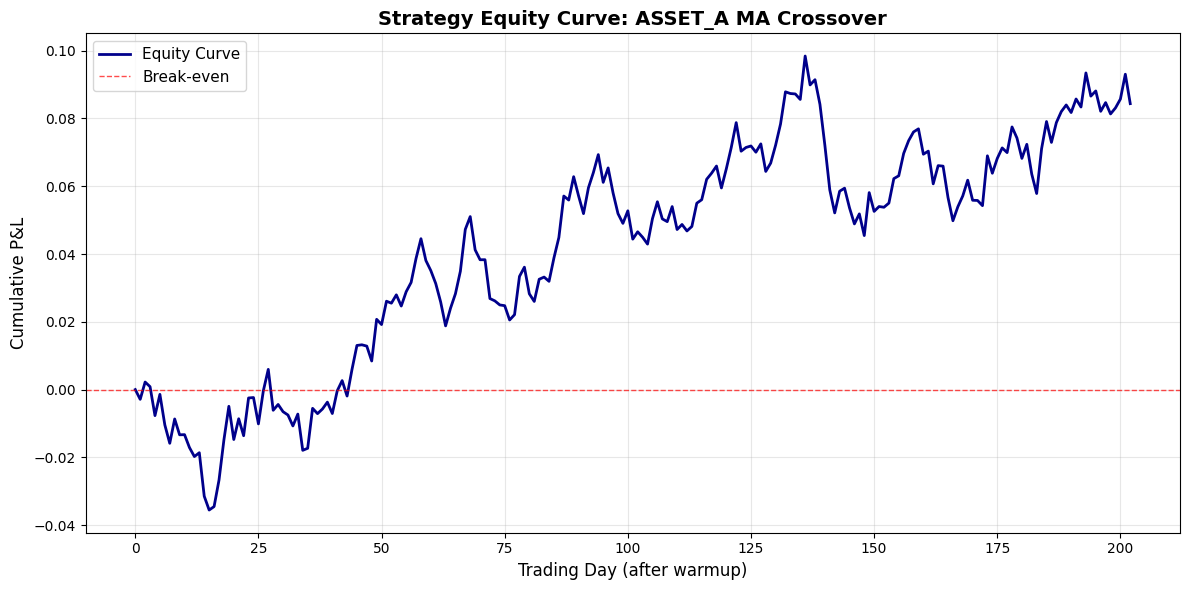


Visualization: Equity curve shows cumulative strategy performance
               Upward trend indicates profitable strategy


In [9]:
# BACKTEST LOOP

# We need returns aligned with signals
# returns[0] is return from price[0] to price[1]
# signal[0] is signal at time 0 (using price[0])
#
# To avoid look-ahead:
# - We use signal[t] to determine position during [t, t+1]
# - We apply this position to return[t] (which is (price[t+1]-price[t])/price[t])
#
# So we loop through returns, using the signal from the corresponding index

target_returns = returns[TARGET_ASSET]

pnl_series = []  # P&L for each period
equity_curve = [0.0]  # Cumulative P&L (starts at 0)

# Start after warmup period
warmup = LONG_WINDOW

for t in range(warmup, len(target_returns)):
    # Position during [t, t+1] is based on signal[t]
    position = signals[t]

    # Return during [t, t+1]
    ret = target_returns[t]

    # P&L for this period
    pnl = position * ret
    pnl_series.append(pnl)

    # Update cumulative equity
    equity_curve.append(equity_curve[-1] + pnl)

n_trades = len(pnl_series)

print(f"\nBacktest Executed:")
print(f"  Warmup periods skipped: {warmup}")
print(f"  Trading periods: {n_trades}")
print(f"  Initial equity: {equity_curve[0]:.6f} (fractional units)")
print(f"  Final equity: {equity_curve[-1]:.6f}")

# %%
# PERFORMANCE METRICS

# Total return (sum of all P&L)
total_pnl = sum(pnl_series)

# Average P&L per period
mean_pnl = compute_mean_manual(pnl_series)

# Volatility of P&L (standard deviation)
std_pnl = compute_std_manual(pnl_series)

# Simple Sharpe-like ratio
# Note: This is simplified; true Sharpe uses excess returns over risk-free rate
# Sharpe = mean(PnL) / std(PnL)
# Annualized: sqrt(252) * daily_sharpe
if std_pnl > 0:
    sharpe_ratio = mean_pnl / std_pnl
    annual_sharpe = sharpe_ratio * math.sqrt(252)
else:
    sharpe_ratio = 0.0
    annual_sharpe = 0.0

# Maximum drawdown (largest peak-to-trough decline)
# Drawdown[t] = (equity[t] - max(equity[0:t])) / max(equity[0:t])
# But since we start at 0, we track absolute equity drops

running_max = equity_curve[0]
max_drawdown = 0.0

for equity in equity_curve:
    if equity > running_max:
        running_max = equity
    drawdown = running_max - equity
    if drawdown > max_drawdown:
        max_drawdown = drawdown

print("\n" + "="*70)
print("PERFORMANCE METRICS")
print("="*70)
print(f"\nTotal P&L:           {total_pnl:>10.6f}  ({total_pnl*100:.4f}%)")
print(f"Mean P&L per period: {mean_pnl:>10.6f}  ({mean_pnl*100:.4f}%)")
print(f"P&L Volatility:      {std_pnl:>10.6f}  ({std_pnl*100:.4f}%)")
print(f"Sharpe Ratio:        {sharpe_ratio:>10.4f}  (daily)")
print(f"Annualized Sharpe:   {annual_sharpe:>10.4f}")
print(f"Max Drawdown:        {max_drawdown:>10.6f}  ({max_drawdown*100:.4f}%)")

print("\nINTERPRETATION:")
print(f"  Sharpe ratio measures risk-adjusted returns (mean/volatility)")
print(f"  Positive Sharpe suggests strategy adds value above random noise")
print(f"  Max drawdown shows worst peak-to-trough decline")

# %%
# EQUITY CURVE VISUALIZATION

plt.figure(figsize=(12, 6))
trading_days = list(range(len(equity_curve)))

plt.plot(trading_days, equity_curve, linewidth=2, color='darkblue', label='Equity Curve')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Break-even')

plt.xlabel("Trading Day (after warmup)", fontsize=12)
plt.ylabel("Cumulative P&L", fontsize=12)
plt.title(f"Strategy Equity Curve: {TARGET_ASSET} MA Crossover", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVisualization: Equity curve shows cumulative strategy performance")
print("               Upward trend indicates profitable strategy")

# %%

## 7.GOVERNANCE

###7.1.OVERVIEW



**BEYOND PERFORMANCE: THE INVISIBLE INFRASTRUCTURE**


A strategy that makes money is not enough. In production quantitative finance,
you need more than profitability—you need **reproducibility, auditability,
interpretability, and continuous monitoring**. This is governance: the unsexy,
underdiscussed, absolutely critical infrastructure that separates toy models from
deployable systems.

Consider these real-world scenarios:

**Scenario 1**: Your strategy made 12% last year. Your boss asks: "What parameters
did you use? Can you prove these were the settings?" Without governance, you shrug.
Maybe you remember. Maybe you don't. Maybe you accidentally re-ran it with different
parameters and don't realize.

**Scenario 2**: Your strategy suddenly starts losing money. Is this normal variance?
A regime change? A bug? Without detailed logs of every decision, you're debugging
blind.

**Scenario 3**: Compliance asks: "On March 15th at 10:32 AM, why did you short
10,000 shares of XYZ?" Without an audit trail linking every trade to the signal,
the model version, and the input data, you have no answer.

Governance prevents these nightmares. It's not optional—it's foundational.

**THE EXPERIMENT CONFIGURATION: REPRODUCIBILITY AS CODE**


We introduce the **experiment configuration dictionary**—a single Python dict that
captures every parameter, setting, and decision that defines our experiment:

- **DGP parameters**: Random seed, drift rates, volatilities, correlations
- **Strategy parameters**: Moving average windows, position sizing rules
- **Execution parameters**: Rebalancing frequency, cost assumptions
- **Metadata**: Experiment ID, date, description

Why this matters:

**Reproducibility**: Six months from now, you—or a colleague—can load this config
and regenerate the exact same results. No ambiguity, no "I think I used window=20."

**Comparability**: Want to test 50-day vs 100-day moving averages? Change one
parameter, re-run, compare. The config dict makes A/B testing systematic, not
ad-hoc.

**Version control**: Store configs in git alongside code. Now your experiments
are versioned, branched, and merged just like software. You can trace the evolution
of your strategy through its parameter history.

This is **configuration as data**—a principle from software engineering that's
equally powerful in quantitative research.

**THE EXPERIMENT LOG: AN AUDIT TRAIL OF DECISIONS**


The experiment log is a timestamped record of every action the strategy took:
- What was the price?
- What was the signal?
- What position did we take?
- What return did we realize?
- What was the resulting P&L?

In our simple notebook, we store this as a list of dictionaries. In production,
this might be a database, a time-series store, or a structured log file. But the
principle is the same: **every decision is recorded with full context**.

Why this matters:

**Debugging**: When P&L deviates from expectations, you can replay the exact
sequence of events. "Ah, on day 137, the signal flipped because the price spiked,
which pushed the short MA above the long MA." Without logs, you're guessing.

**Post-trade analysis**: Did we make money on long positions or short positions?
During high-volatility periods or calm periods? Logs let you slice and analyze
performance by regime, signal strength, or market condition.

**Compliance and audit**: In regulated environments, you must explain every trade.
Logs provide the paper trail: "This trade was generated by model v2.3, using these
inputs, producing this signal, which triggered this execution rule."




###7.2.CODE AND IMPLEMENTATION

In [10]:
# %%
# EXPERIMENT CONFIGURATION

experiment_config = {
    "experiment_id": "lab01_ma_crossover_v1",
    "date_created": "2024-12-11",
    "description": "Dual moving average crossover on synthetic Asset A",

    # DGP parameters
    "dgp": {
        "random_seed": RANDOM_SEED,
        "n_days": N_DAYS,
        "initial_price": INITIAL_PRICE,
        "target_asset": TARGET_ASSET,
        "asset_a_drift": DRIFT_A,
        "asset_a_vol": VOL_A,
        "market_shock_weight": MARKET_SHOCK_WEIGHT,
    },

    # Strategy parameters
    "strategy": {
        "type": "moving_average_crossover",
        "short_window": SHORT_WINDOW,
        "long_window": LONG_WINDOW,
        "target_asset": TARGET_ASSET,
    },

    # Execution parameters
    "execution": {
        "position_sizing": "fixed_unit",  # +1/-1 positions
        "rebalance_frequency": "daily",
        "transaction_costs": 0.0,  # Not yet implemented
    },
}

print("="*70)
print("EXPERIMENT CONFIGURATION")
print("="*70)
print(f"\nExperiment ID: {experiment_config['experiment_id']}")
print(f"Description: {experiment_config['description']}")
print(f"\nDGP Parameters:")
for key, value in experiment_config['dgp'].items():
    print(f"  {key}: {value}")
print(f"\nStrategy Parameters:")
for key, value in experiment_config['strategy'].items():
    print(f"  {key}: {value}")

# %%
# EXPERIMENT LOG (Sample)

# For large backtests, we'd log every step
# Here we show the structure with first and last few entries

experiment_log = []

# Log entries during trading period
for i in range(min(5, len(pnl_series))):  # First 5 entries
    t = warmup + i
    log_entry = {
        "step": i,
        "day": t,
        "price": target_prices[t],
        "signal": signals[t],
        "position": signals[t],  # In this simple case, position = signal
        "return": target_returns[t],
        "pnl": pnl_series[i],
        "cumulative_pnl": equity_curve[i+1],
    }
    experiment_log.append(log_entry)

# Add ellipsis marker
if len(pnl_series) > 10:
    experiment_log.append({"step": "...", "note": "middle entries omitted"})

# Last 5 entries
for i in range(max(5, len(pnl_series)-5), len(pnl_series)):
    t = warmup + i
    log_entry = {
        "step": i,
        "day": t,
        "price": target_prices[t],
        "signal": signals[t],
        "position": signals[t],
        "return": target_returns[t],
        "pnl": pnl_series[i],
        "cumulative_pnl": equity_curve[i+1],
    }
    experiment_log.append(log_entry)

print("\n" + "="*70)
print("EXPERIMENT LOG (Sample Entries)")
print("="*70)
print("\nThis log captures step-by-step strategy decisions and outcomes.")
print("Full log would contain all {} trading periods.\n".format(len(pnl_series)))

# Print sample log entries
for entry in experiment_log[:6]:  # First 5 + ellipsis
    if "note" in entry:
        print(f"\n  [{entry['step']}] {entry['note']}\n")
    else:
        print(f"  Day {entry['day']:>3} | Signal: {entry['signal']:>2} | "
              f"Price: ${entry['price']:>7.2f} | Ret: {entry['return']:>7.4f} | "
              f"P&L: {entry['pnl']:>8.5f} | Cum: {entry['cumulative_pnl']:>8.5f}")

if len(experiment_log) > 6:
    print("\n  Last 5 entries:")
    for entry in experiment_log[-5:]:
        print(f"  Day {entry['day']:>3} | Signal: {entry['signal']:>2} | "
              f"Price: ${entry['price']:>7.2f} | Ret: {entry['return']:>7.4f} | "
              f"P&L: {entry['pnl']:>8.5f} | Cum: {entry['cumulative_pnl']:>8.5f}")


EXPERIMENT CONFIGURATION

Experiment ID: lab01_ma_crossover_v1
Description: Dual moving average crossover on synthetic Asset A

DGP Parameters:
  random_seed: 42
  n_days: 252
  initial_price: 100.0
  target_asset: ASSET_A
  asset_a_drift: 0.0001984126984126984
  asset_a_vol: 0.00629940788348712
  market_shock_weight: 0.4

Strategy Parameters:
  type: moving_average_crossover
  short_window: 20
  long_window: 50
  target_asset: ASSET_A

EXPERIMENT LOG (Sample Entries)

This log captures step-by-step strategy decisions and outcomes.
Full log would contain all 202 trading periods.

  Day  50 | Signal: -1 | Price: $ 100.85 | Ret:  0.0029 | P&L: -0.00289 | Cum: -0.00289
  Day  51 | Signal: -1 | Price: $ 101.14 | Ret: -0.0051 | P&L:  0.00511 | Cum:  0.00222
  Day  52 | Signal: -1 | Price: $ 100.62 | Ret:  0.0014 | P&L: -0.00137 | Cum:  0.00085
  Day  53 | Signal: -1 | Price: $ 100.76 | Ret:  0.0085 | P&L: -0.00854 | Cum: -0.00769
  Day  54 | Signal: -1 | Price: $ 101.62 | Ret: -0.0063 | P&L

##8.CONCLUSIONS


**FROM DATA TO WISDOM**


The final piece of governance is **interpretation**—stepping back from the numbers
and asking: What did we learn? What worked? What failed? What assumptions held or
broke?

This is where science happens. Our moving average strategy captured some of Asset A's
positive drift—that's good. But it also lagged price movements and would suffer in
mean-reverting markets—that's a limitation. By explicitly articulating these
insights, we build intuition that guides future work.

Reflection also means **acknowledging unknowns**:
- We tested one parameter set on one synthetic path—are results robust?
- We ignored transaction costs—how sensitive is performance to costs?
- We traded a single asset—how would a portfolio behave?

Listing these questions isn't weakness—it's intellectual honesty. It prevents
overconfidence and motivates the next experiment.

**THE GOVERNANCE MINDSET: SYSTEMS THINKING FOR TRADING**


Most tutorials end with "here's the Sharpe ratio, we're done." We go further. We
treat our trading strategy not as a one-off script but as a **system** that must:
- Be understood by others (documentation, configs)
- Be debugged when it fails (logs, traces)
- Be improved over time (version control, comparisons)
- Be trusted by stakeholders (audit trails, interpretations)

This governance infrastructure—configs, logs, reflection—might seem like overhead
for a simple moving average strategy. But it's a **habit**, and habits scale. When
you're managing dozens of models, multiple asset classes, and millions of dollars,
these habits become non-negotiable.

We're not just building a strategy. We're building a **practice**—a disciplined,
systematic approach to quantitative research that will serve you from this first
notebook through your entire career.

**THE FOUNDATION IS COMPLETE**


You've now seen the full cycle: generate data, explore it, create signals, backtest,
evaluate, and govern. This is the workflow. Every subsequent notebook will operate
within this framework, adding sophistication to each component while maintaining
the same structural discipline.

Next, we'll add machine learning. Then deep learning. Then reinforcement learning.
Then multi-agent systems. But the core pattern—data, signal, execution, evaluation,
governance—remains constant.

You've built the foundation. Now we build the tower.

